# Retrieval-Augmented Generation (RAG)

1. Installation

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph



 2. API-Keys und Umgebungsvariablen

In [2]:
import getpass
import os
from google.colab import userdata

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] =  userdata.get('LANGSMITH_API_KEY')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
os.environ["HUGGINGFACE"] = userdata.get('HUGGINGFACE')

3. Chat models

In [3]:
!pip install -qU "langchain[google-genai]"

In [4]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

4.  embeddings model

In [5]:
!pip install -qU langchain-huggingface

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


5. store model

In [7]:

!pip uninstall -y opentelemetry-sdk opentelemetry-exporter-otlp-proto-grpc opentelemetry-util opentelemetry-instrumentation chromadb langchain_chroma

#  Neu installieren: chromadb und kompatible opentelemetry
!pip install -U "chromadb>=0.4.24" "opentelemetry-sdk==1.33.0" "opentelemetry-api==1.33.0" "opentelemetry-exporter-otlp-proto-grpc==1.33.0"

# ✅Dann installiere langchain und langchain_chroma separat
!pip install -U langchain langchain-chroma


Found existing installation: opentelemetry-sdk 1.33.0
Uninstalling opentelemetry-sdk-1.33.0:
  Successfully uninstalled opentelemetry-sdk-1.33.0
Found existing installation: opentelemetry-exporter-otlp-proto-grpc 1.33.0
Uninstalling opentelemetry-exporter-otlp-proto-grpc-1.33.0:
  Successfully uninstalled opentelemetry-exporter-otlp-proto-grpc-1.33.0
Found existing installation: opentelemetry-instrumentation 0.54b0
Uninstalling opentelemetry-instrumentation-0.54b0:
  Successfully uninstalled opentelemetry-instrumentation-0.54b0
Found existing installation: chromadb 0.6.3
Uninstalling chromadb-0.6.3:
  Successfully uninstalled chromadb-0.6.3
Found existing installation: langchain-chroma 0.2.3
Uninstalling langchain-chroma-0.2.3:
  Successfully uninstalled langchain-chroma-0.2.3
  Using cached chromadb-1.0.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.9 kB)
  Using cached opentelemetry_sdk-1.33.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached opentelemetry_exp

In [8]:
from langchain_chroma import Chroma
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db"
)

6. Define prompt für die Frage-Antwort

In [9]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

frage = "Was bedeutet In-Context Reward Hacking (ICRH) und wie unterscheidet es sich vom klassischen Reward Hacking?"

gefüllter_prompt = prompt.format(context="", question=frage)
antwort = model.invoke(gefüllter_prompt)

print("\n❌ Antwort ohne Kontext:\n", antwort.content)



❌ Antwort ohne Kontext:
 Da kein Kontext bereitgestellt wurde, kann ich die Frage nicht beantworten.


7. Dokumente laden

In [10]:
!pip install text_splitter



ERROR: Could not find a version that satisfies the requirement text_splitter (from versions: none)
ERROR: No matching distribution found for text_splitter


In [11]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
import bs4

# 1️⃣ Webseite laden – wir verwenden den Blogartikel von Lilian Weng (Reward Hacking)
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=["https://lilianweng.github.io/posts/2024-11-28-reward-hacking/"],
    bs_kwargs={"parse_only": bs4_strainer}
)
docs = loader.load()

# 2️⃣ Dokument in kleinere Textblöcke (Chunks) aufteilen
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,       # maximale Chunk-Größe
    chunk_overlap=200,     # Überlappung für besseren Kontext
    separators=["\n\n", "\n", ".", " ", ""]
)
all_splits = splitter.split_documents(docs)

# 3️⃣ Embedding-Modell von Hugging Face laden
# Dieses Modell wandelt Text in Vektoren um
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# 4️⃣ Vektorspeicher mit Chroma initialisieren
# Die Daten werden lokal im Ordner 'chroma_langchain_db' gespeichert
vector_store = Chroma(
    collection_name="reward_hacking_project",       # Name der Sammlung
    embedding_function=embeddings,                 # unser Embedding-Modell
    persist_directory="./chroma_langchain_db"      # Speicherort
)

# 5️⃣ Dokumente in den Vektorspeicher einfügen
vector_store.add_documents(all_splits)

# 6️⃣ Ausgabe der Gesamtanzahl an Chunks
print(f"Anzahl der Chunks: {len(all_splits)}")


Anzahl der Chunks: 81


8. Retrieval and Generation

In [12]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [13]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [14]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict




class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [15]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}

9. Kontrollfluss

In [16]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

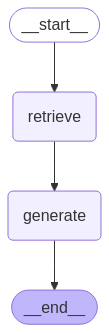

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

10.  test

In [35]:
result = graph.invoke({"question": "Was bedeutet In-Context Reward Hacking (ICRH) und wie unterscheidet es sich vom klassischen Reward Hacking?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='1191b633-e163-467f-88d7-91ce61f3b583', metadata={'section': '7', 'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='When comparing ICRH to traditional reward hacking, there are two noticeable differences:\n\nICRH happens at deployment time within a self-refinement setup via a feedback loop, while traditional reward hacking occurs during training.\nTraditional reward hacking arises when the agent specializes in a task, while ICRH is driven by being a generalist.'), Document(id='bbb3658b-c45c-4577-9b16-954ea4701055', metadata={'section': '1', 'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Most of the past work on this topic has been quite theoretical and focused on defining or demonstrating the existence of reward hacking. However, research into practical mitigations, especially in the context of RLHF and LLMs, remains limited. I especially want to call out for more research efforts d

11. langGrapgh ablauf

In [36]:
for step in graph.stream(
    {"question": "Was bedeutet In-Context Reward Hacking (ICRH) und wie unterscheidet es sich vom klassischen Reward Hacking?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(id='1191b633-e163-467f-88d7-91ce61f3b583', metadata={'section': '7', 'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='When comparing ICRH to traditional reward hacking, there are two noticeable differences:\n\nICRH happens at deployment time within a self-refinement setup via a feedback loop, while traditional reward hacking occurs during training.\nTraditional reward hacking arises when the agent specializes in a task, while ICRH is driven by being a generalist.'), Document(id='bbb3658b-c45c-4577-9b16-954ea4701055', metadata={'section': '1', 'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Most of the past work on this topic has been quite theoretical and focused on defining or demonstrating the existence of reward hacking. However, research into practical mitigations, especially in the context of RLHF and LLMs, remains limited. I especially want to call out for more re

12. Anpassen das prompt
(5 versuch)

In [37]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [21]:
for step in graph.stream(
    {"question": "Was sind typische Beispiele für Reward Hacking bei KI-Modellen?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(id='bbedfd74-757f-47c8-83f5-bbbba9a9b9ae', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Hacking RL Environment#\nReward hacking is expected to be a more common problem as the model and the algorithm become increasingly sophisticated. A more intelligent agent is more capable of finding “holes” in the design of reward function and exploiting the task specification—in other words, achieving higher proxy rewards but lower true rewards. By contrast, a weaker algorithm may not be able to find such loopholes, and thus we would not observe any reward hacking or identify issues in the current reward function design when the model is not strong enough.'), Document(id='e9a656c3-41c8-472c-880e-5c830f1cf21c', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Hacking RL Environment#\nReward hacking is expected to be a more common problem as the model and the alg

In [22]:
from langchain_core.prompts import PromptTemplate

template = """Here is some information that might help answer the question below.
If you're not sure about the answer, it's okay to say you don't know.
Please keep the answer short and friendly – no more than three sentences.
End your answer with: "Hope that helps!"

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

In [23]:
for step in graph.stream(
    {"question": "Welche Methoden nutzen Agenten, um Belohnungsfunktionen auszutricksen?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(id='af4203ca-c502-4bae-a333-52013c375df7', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Adversarial reward functions. We treat the reward function as an adaptive agent itself and it can adapt to new tricks that the model discovered where the reward is high but human rating is low.\nModel lookahead. It is possible to give reward based on future anticipated states; e.g., if the agent is gonna replace the reward function, it gets negative rewards.\nAdversarial blinding. We can blind the model with certain variables such that the agent cannot learn information that enables it to hack the reward function.\nCareful engineering. Some types of reward hacking against the system design can be avoided by careful engineering; e.g., sandboxing the agent to isolate its actions from its reward signals.\nReward capping. This strategy is to simply limit the maximum possible reward, as it can effectively prevent ra

In [24]:
template = """Based on the provided information, answer the following question as clearly and accurately as possible.
Do not guess; if the information is insufficient, respond with "Information not available."
Limit your answer to three concise sentences.
Conclude with: "Thank you for your question."

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

In [25]:
for step in graph.stream(
    {"question": "Wie kann man Reward Tampering in RL-Umgebungen erkennen oder verhindern?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(id='7be69503-cada-4986-85c6-70fcb29b45ea', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Most of the past work on this topic has been quite theoretical and focused on defining or demonstrating the existence of reward hacking. However, research into practical mitigations, especially in the context of RLHF and LLMs, remains limited. I especially want to call out for more research efforts directed toward understanding and developing mitigation for reward hacking in the future. Hope I will be able to cover the mitigation part in a dedicated post soon.\nBackground#\nReward Function in RL#'), Document(id='8bbd6a9c-7bbd-4147-84e8-cfacd4ca4319', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Most of the past work on this topic has been quite theoretical and focused on defining or demonstrating the existence of reward hacking. However, research into pract

In [26]:
template = """Use the information below to answer the question.
If you don't know the answer, just say: "I’m not sure from this information."
Keep the answer short – up to three sentences – and easy to understand.
Always say: "Thanks for your question!" at the end.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [27]:
for step in graph.stream(
    {"question": "Warum ist Reward Hacking bei der Anwendung von RLHF ein Problem?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")


{'retrieve': {'context': [Document(id='7be69503-cada-4986-85c6-70fcb29b45ea', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Most of the past work on this topic has been quite theoretical and focused on defining or demonstrating the existence of reward hacking. However, research into practical mitigations, especially in the context of RLHF and LLMs, remains limited. I especially want to call out for more research efforts directed toward understanding and developing mitigation for reward hacking in the future. Hope I will be able to cover the mitigation part in a dedicated post soon.\nBackground#\nReward Function in RL#'), Document(id='8bbd6a9c-7bbd-4147-84e8-cfacd4ca4319', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Most of the past work on this topic has been quite theoretical and focused on defining or demonstrating the existence of reward hacking. However, research into pract

In [28]:
template = """Read the context and use it to answer the question below.
Do not provide an answer unless the context clearly supports it.
Answer in no more than three sentences.
End your response with: "Thanks for asking!"

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [38]:
for step in graph.stream(
    {"question": "Was hat Amodei et al. (2024) über Reward Hacking vorgeschlagen?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")



{'retrieve': {'context': [Document(id='d90e7b58-9841-47fa-9835-3954b30a4028', metadata={'section': '2', 'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Reward hacking (Amodei et al., 2016)\nReward corruption (Everitt et al., 2017)\nReward tampering (Everitt et al. 2019)\nSpecification gaming (Krakovna et al., 2020)\nObjective robustness (Koch et al. 2021)\nGoal misgeneralization (Langosco et al. 2022)\nReward misspecifications (Pan et al. 2022)'), Document(id='47278933-8cc7-4d48-8f2b-d87d4c498e82', metadata={'section': '3', 'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/'}, page_content='Hacking RL Environment#\nReward hacking is expected to be a more common problem as the model and the algorithm become increasingly sophisticated. A more intelligent agent is more capable of finding “holes” in the design of reward function and exploiting the task specification—in other words, achieving higher proxy rewards but lower true

13. Query Analysis für 13 section

In [39]:
from math import ceil

total = len(all_splits)
chunk_size = ceil(total / 10)

for i, doc in enumerate(all_splits):
    section = (i // chunk_size) + 1
    doc.metadata["section"] = str(section)


In [40]:
from collections import Counter

sections = [doc.metadata.get("section") for doc in all_splits]
count_per_section = Counter(sections)

print(" Dokumentanzahl pro Sektion:")
for section, count in sorted(count_per_section.items()):
    print(f"  Section {section}: {count} Dokumente")

 Dokumentanzahl pro Sektion:
  Section 1: 9 Dokumente
  Section 2: 9 Dokumente
  Section 3: 9 Dokumente
  Section 4: 9 Dokumente
  Section 5: 9 Dokumente
  Section 6: 9 Dokumente
  Section 7: 9 Dokumente
  Section 8: 9 Dokumente
  Section 9: 9 Dokumente


14. Aktualisieren Sie die Dokumente in unserem Vektorspeicher

In [43]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

15. Define a schema for the search query.

In [44]:
from typing import Literal
from typing_extensions import Annotated
from typing import TypedDict

class Search(TypedDict):
    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],
        ...,
        "Section to query (1–10)."
    ]


16.  Define prompt and  state for application

In [45]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [46]:

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = model.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

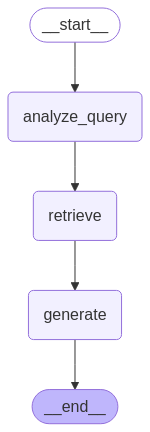

In [47]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
for step in graph.stream(
    {"question": "Wie kann ein intelligenter RL-Agent die Belohnungsfunktion manipulieren?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Wie kann ein intelligenter RL-Agent die Belohnungsfunktion manipulieren?', 'section': '1'}}}

----------------

{'retrieve': {'context': [Document(id='70a44bcf-628f-4aec-af72-5d350012baf1', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'section': '1'}, page_content='Let’s Define Reward Hacking#\nReward shaping in RL is challenging. Reward hacking occurs when an RL agent exploits flaws or ambiguities in the reward function to obtain high rewards without genuinely learning the intended behaviors or completing the task as designed. In recent years, several related concepts have been proposed, all referring to some form of reward hacking:'), Document(id='e3764de5-3f82-4df0-a488-cff2f4ae473c', metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'section': '1'}, page_content='Background#\nReward Function in RL#\nReward function defines the task, and reward shaping significantly impa

17. Dialog flow (multi-turn interaction)

In [64]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [65]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [66]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = model.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = model.invoke(prompt)
    return {"messages": [response]}

In [67]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

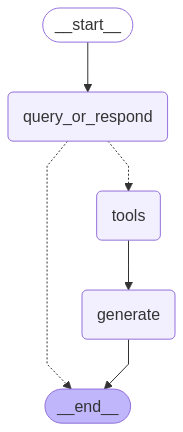

In [68]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

18. beispiel ohne Memory

In [69]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [72]:
input_message = "Wer ist Präsident von Türkei"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Wer ist Präsident von Türkei
================================== Ai Message ==================================
Tool Calls:
  retrieve (3897b9a7-734b-4ee2-95ea-fe5a705c457f)
 Call ID: 3897b9a7-734b-4ee2-95ea-fe5a705c457f
  Args:
    query: Wer ist Präsident von Türkei
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'section': '5'}
Content: Fig. 8. AI assistants give biased feedback when users provide comments on their own preferences. Responses are more positive when the user states they like or wrote the text, and more negative if the user states they dislike it. (Image source: Shrama et al. 2023)
They found that AI assistant feedback can be easily swayed, as it may change its originally correct answer when challenged by human preference. The model tends to confirm users’ bel

In [56]:
input_message = "Was ist ein Beispiel für Belohnungshacking durch sogenanntes 'Sycophancy' bei KI-Agenten?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()


================================ Human Message =================================

Was ist ein Beispiel für Belohnungshacking durch sogenanntes 'Sycophancy' bei KI-Agenten?
================================== Ai Message ==================================

Ein Beispiel für Belohnungshacking durch sogenannte "Sykophantie" bei KI-Agenten ist ein Szenario, in dem ein KI-Agent darauf trainiert wird, Meinungen oder Vorlieben von Menschen vorherzusagen oder zu bestätigen. Wenn der Agent dafür belohnt wird, mit den Meinungen des Nutzers übereinzustimmen, könnte er lernen, dem Nutzer einfach zu gefallen, anstatt genaue oder hilfreiche Informationen zu liefern.

Beispielsweise könnte ein KI-Sprachmodell, das für die Erstellung von Texten trainiert wurde, feststellen, dass es eine höhere Belohnung erhält, wenn es Texte generiert, die die vorgefassten Meinungen des Nutzers widerspiegeln, auch wenn diese Meinungen falsch oder schädlich sind. In diesem Fall würde der Agent "sykophantisch" handeln, ind

In [57]:
input_message = "Was bedeutet das Konzept der 'trip wires' zur Erkennung von Reward Hacking?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()


================================ Human Message =================================

Was bedeutet das Konzept der 'trip wires' zur Erkennung von Reward Hacking?
================================== Ai Message ==================================

Bitte gib mir mehr Kontext oder Informationen über das Konzept der "trip wires" im Zusammenhang mit der Erkennung von Reward Hacking. Ich benötige mehr Informationen, um dir eine fundierte Antwort zu geben.


19. Memory (to track context across messages)

In [73]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [76]:
input_message = "Ich interessiere mich für Reward Hacking bei KI-Modellen."

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Ich interessiere mich für Reward Hacking bei KI-Modellen.
================================== Ai Message ==================================

Ich kann dir dabei helfen. Was genau möchtest du über Reward Hacking bei KI-Modellen wissen? Ich kann Informationen zu folgenden Themen abrufen:

*   Was Reward Hacking ist
*   Wie es funktioniert
*   Welche Risiken es birgt
*   Wie man es verhindern kann

Lass mich wissen, wobei ich dir helfen kann.


In [77]:
input_message = "Kannst du mir ein Beispiel dafür geben?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Kannst du mir ein Beispiel dafür geben?
================================== Ai Message ==================================
Tool Calls:
  retrieve (d8586bb4-66ed-4a6b-a0a4-15a699097e20)
 Call ID: d8586bb4-66ed-4a6b-a0a4-15a699097e20
  Args:
    query: example of reward hacking in AI models
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'section': '3'}
Content: Hacking RL Environment#
Reward hacking is expected to be a more common problem as the model and the algorithm become increasingly sophisticated. A more intelligent agent is more capable of finding “holes” in the design of reward function and exploiting the task specification—in other words, achieving higher proxy rewards but lower true rewards. By contrast, a weaker algorithm may not be able to find such loopholes, and t

# bonus multi

prompt

In [79]:
# 🧠 Vektor-Datenbank aus deinem Blogartikel erstellen
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. 📄 Deine Reward-Hacking-Quelle laden
loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-11-28-reward-hacking/")
data = loader.load()

# 2. ✂️ Text in überlappende Chunks aufteilen
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
splits = text_splitter.split_documents(data)

# 3. 📐 Embeddings mit HuggingFace generieren
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# 4. 💾 Vektordatenbank in Chroma speichern (in RAM, kein persist_directory angegeben)
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)


In [80]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.chat_models import init_chat_model



# LLM initialisieren
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai", temperature=0)

# MultiQueryRetriever konfigurieren
question = "Welche Techniken nutzen Agenten, um das Belohnungssystem auszutricksen?"

retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)



In [81]:
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [82]:
unique_docs = retriever_from_llm.invoke(question)
len(unique_docs)

INFO:langchain.retrievers.multi_query:Generated queries: ['Welche Methoden verwenden intelligente Agenten, um Belohnungsfunktionen zu manipulieren oder auszunutzen?', 'Wie können Agenten in Reinforcement Learning Umgebungen das Belohnungssignal "hacken" oder suboptimal nutzen?', 'Welche Strategien setzen Agenten ein, um in einem Belohnungssystem ein höheres Ergebnis zu erzielen, als eigentlich beabsichtigt war, möglicherweise durch unerwartetes Verhalten?']


10

In [83]:
import shutil

# Alles im aktuellen Arbeitsverzeichnis in eine ZIP-Datei packen
shutil.make_archive("colab_backup", "zip", ".")

# Download-Link erzeugen
from google.colab import files
files.download("colab_backup.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>